# Capstone Project: NBA Playoff Predictive Analysis
Author: Preston Weaver

This notebook explores the relationship between NBA regular season performance and playoff success. By leveraging team regular season statistics, we build predictive models to estimate the number of playoff wins a team is likely to achieve. The workflow includes data preprocessing, feature selection, model building, and performance evaluation.

We experiment with multiple modeling approaches to compare their effectiveness in capturing the patterns that lead to postseason success. The ultimate goal is to identify key regular season indicators of playoff performance and develop models that generalize well to unseen data. A target RMSE of less than 4 was chosen, reflecting the fact that it takes 4 wins to win a playoff series, making this a meaningful benchmark for predictive accuracy.

## Setup

In [ ]:
install.packages("tidyverse")
install.packages('sjstats')

In [ ]:
library(tidyverse)
library(sjstats)

In [ ]:
nba <- read.csv('Regular_Season_Stats.csv')

## Data Transformation

As many avid NBA fans know, the game of basketball has changed quite a bit in the past twenty-five years. This is evident in various statistics, but for illustration, consider points per game (PPG). In the 2000 season, the league average for PPG was 97.5, with the highest-scoring team averaging 105 PPG. By the 2024 season, the league average had risen to 114 PPG, and even the lowest-scoring team averaged 105.8 PPG. In other words, the worst-scoring team in 2024 would have been the best-scoring team in 2000. Given this shift, an adjustment was needed to account for the changes in the statistical landscape of the NBA.

To account for these changes, a Z-score transformation was applied to the data. Each statistic was standardized within its season by subtracting the season’s mean and dividing by the season’s standard deviation. This process ensured that all statistics are contextualized relative to their respective season, allowing for more meaningful comparisons across years.


In [ ]:
nba |>
  group_by(Season) |>
  summarise(
    PPG = mean(PTS),
    Min = min(PTS),
    Max = max(PTS)
  )

Season,PPG,Min,Max
<int>,<dbl>,<dbl>,<dbl>
2000,97.47586,84.8,105.0
2001,94.81034,87.6,101.7
2002,95.47241,87.2,105.2
2003,95.08966,84.2,103.0
2004,93.39655,85.4,105.2
2005,97.19000,88.4,110.4
2006,97.01333,88.8,108.4
2007,98.74000,93.7,110.2
2008,99.92333,91.4,111.0


In [ ]:
# Adding Standardized values to the Dataframe
Scaled_Values <- nba |>
  group_by(Season) |>
  # Create new fields of scaled values
  mutate(
    across(c(FG, FGA, FG_percent, X3P, X3P_percent, X2P, X2PA, X2P_percent,
             FT, FTA, FT_percent, ORB, DRB, TRB, AST, STL, BLK, TOV, PF,
             PTS, Assist_TO, Opp_FG, Opp_FGA, Opp_FG_percent, Opp_3P, Opp_3PA,
             Opp_3P_percent, Opp_2P, Opp_2PA, Opp_2P_percent, Opp_FT, Opp_FTA,
             Opp_FT_percent, Off_Reb_Allowed, Opp_DRB, Opp_Total_Reb, Opp_AST,
             Opp_STL, TO_Forced, Points_Allowed, Age, MOV, SOS, SRS, ORtg, DRtg,
             NRtg, Pace, FTr, X3PAr, TS_percent, eFG_percent, ORB_percent,
             FT_FGA, Def_eFG_percent, Def_TOV_percent, DRB_percent, Def_FT_FGA,
             Seed),
             scale,  # Use the scale function to preform a z score standardization
             .names = "scaled_{col}")  # Change name to start with 'scaled'
  ) |>
  ungroup()


In [ ]:
# House keeping
Scaled_Values_Playoff <- Scaled_Values |>
  filter(Playoff == 1 & Season != 2024)  # Only want to include teams that made the playoffs
                                         # Saving 2024 as a test year

In [ ]:
nrow(Scaled_Values_Playoff)

[1] 384

The following teams underpreformed in large part due to injuries that occured in the playoffs. Seeing that the post season performance wasn't a very accurate reflection of the regular season performance, they were removed from the dataset.

In [ ]:
# Remove Outliers
Scaled_Values_Playoff <- Scaled_Values_Playoff |>
  filter(!(Team == 'Miami Heat' & Season == 2023) &
            !(Team == 'Milwaukee Bucks' & Season == 2023) &
            !(Team == 'Chicago Bulls' & Season == 2012) &
            !(Team == 'Philadelphia 76ers' & Season == 2012) &
            !(Team == 'Oklahoma City Thunder' & Season == 2013) &
            !(Team == 'Memphis Grizzlies' & Season == 2013))




In [ ]:
nrow(Scaled_Values_Playoff)

[1] 378

In [ ]:
# Splitting the data set
set.seed(2016)
split_index <- sample(nrow(Scaled_Values_Playoff), nrow(Scaled_Values_Playoff) * .8)
train <- Scaled_Values_Playoff[split_index,]
test <- Scaled_Values_Playoff[-split_index,]

## MLR

### Model 1

In [ ]:
model1 <- lm(Wins ~ scaled_FG + scaled_FGA + scaled_FG_percent + scaled_X3P +
             scaled_X3P_percent + scaled_X2P + scaled_X2PA + scaled_X2P_percent + scaled_FT +
             scaled_FTA + scaled_FT_percent + scaled_ORB + scaled_DRB + scaled_TRB + scaled_AST +
             scaled_STL + scaled_BLK + scaled_TOV + scaled_PF + scaled_PTS + scaled_Assist_TO + scaled_Opp_FG +
             scaled_Opp_FGA + scaled_Opp_FG_percent + scaled_Opp_3P + scaled_Opp_3PA + scaled_Opp_3P_percent +
             scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_2P_percent + scaled_Opp_FT + scaled_Opp_FTA +
             scaled_Opp_FT_percent + scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb +
             scaled_Opp_AST + scaled_Opp_STL + scaled_TO_Forced + scaled_Points_Allowed + scaled_Age +
             scaled_MOV + scaled_SOS + scaled_SRS + scaled_ORtg + scaled_DRtg + scaled_NRtg + scaled_Pace +
             scaled_FTr + scaled_X3PAr + scaled_TS_percent + scaled_eFG_percent + scaled_ORB_percent +
             scaled_FT_FGA + scaled_Def_eFG_percent + scaled_Def_TOV_percent + scaled_DRB_percent + scaled_Def_FT_FGA +
             win_percentage + Top10_Scorer + Top10_Rebounder + scaled_Seed,
            data = train)

In [ ]:
summary(model1)


Call:
lm(formula = Wins ~ scaled_FG + scaled_FGA + scaled_FG_percent + 
    scaled_X3P + scaled_X3P_percent + scaled_X2P + scaled_X2PA + 
    scaled_X2P_percent + scaled_FT + scaled_FTA + scaled_FT_percent + 
    scaled_ORB + scaled_DRB + scaled_TRB + scaled_AST + scaled_STL + 
    scaled_BLK + scaled_TOV + scaled_PF + scaled_PTS + scaled_Assist_TO + 
    scaled_Opp_FG + scaled_Opp_FGA + scaled_Opp_FG_percent + 
    scaled_Opp_3P + scaled_Opp_3PA + scaled_Opp_3P_percent + 
    scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_2P_percent + 
    scaled_Opp_FT + scaled_Opp_FTA + scaled_Opp_FT_percent + 
    scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb + 
    scaled_Opp_AST + scaled_Opp_STL + scaled_TO_Forced + scaled_Points_Allowed + 
    scaled_Age + scaled_MOV + scaled_SOS + scaled_SRS + scaled_ORtg + 
    scaled_DRtg + scaled_NRtg + scaled_Pace + scaled_FTr + scaled_X3PAr + 
    scaled_TS_percent + scaled_eFG_percent + scaled_ORB_percent + 
    scaled_FT_FGA + scaled_Def_e

In [ ]:
rmse(model1)

[1] 2.860382

### Model 2

In [ ]:
model2 <- lm(Wins ~ scaled_X2P + scaled_FTA + scaled_Opp_FG + scaled_Opp_FGA +
             scaled_Opp_2P + scaled_TO_Forced + scaled_FTr + scaled_TS_percent +
             scaled_Def_TOV_percent + scaled_DRB_percent + Top10_Scorer + scaled_Seed,
            data = train)

In [ ]:
summary(model2)


Call:
lm(formula = Wins ~ scaled_X2P + scaled_FTA + scaled_Opp_FG + 
    scaled_Opp_FGA + scaled_Opp_2P + scaled_TO_Forced + scaled_FTr + 
    scaled_TS_percent + scaled_Def_TOV_percent + scaled_DRB_percent + 
    Top10_Scorer + scaled_Seed, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3301 -1.9655 -0.3072  1.8846  9.2183 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.33335    0.39297  11.027   <2e-16 ***
scaled_X2P              0.20279    0.20428   0.993   0.3217    
scaled_FTA             -0.62492    1.13425  -0.551   0.5821    
scaled_Opp_FG          -0.42846    0.64975  -0.659   0.5101    
scaled_Opp_FGA          0.23006    0.59885   0.384   0.7011    
scaled_Opp_2P           0.07367    0.43922   0.168   0.8669    
scaled_TO_Forced        0.20350    1.47983   0.138   0.8907    
scaled_FTr              0.60761    1.10662   0.549   0.5834    
scaled_TS_percent       0.63715    0.34409   1.852   0.065

In [ ]:
rmse(model2)

[1] 3.206906

### Model 3

In [ ]:
model3 <- lm(Wins ~ scaled_TO_Forced + scaled_TS_percent + scaled_Def_TOV_percent +
             scaled_DRB_percent + Top10_Scorer + scaled_Seed,
           data = train)

In [ ]:
summary(model3)


Call:
lm(formula = Wins ~ scaled_TO_Forced + scaled_TS_percent + scaled_Def_TOV_percent + 
    scaled_DRB_percent + Top10_Scorer + scaled_Seed, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4928 -2.1329 -0.2901  1.9784  9.3955 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.51134    0.30035  15.020   <2e-16 ***
scaled_TO_Forced        0.03469    0.68265   0.051   0.9595    
scaled_TS_percent       0.64765    0.27076   2.392   0.0174 *  
scaled_Def_TOV_percent  0.11404    0.65647   0.174   0.8622    
scaled_DRB_percent      0.40820    0.24810   1.645   0.1010    
Top10_Scorer            0.62956    0.34523   1.824   0.0692 .  
scaled_Seed            -3.24496    0.22775 -14.248   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.258 on 295 degrees of freedom
Multiple R-squared:  0.5404,	Adjusted R-squared:  0.531 
F-statistic: 57.81 on 6 and 295 DF,  p

In [ ]:
rmse(model3)

[1] 3.220143

All predictors are now significant.

$R^2$ = ~0.52

RMSE = 3.25 wins

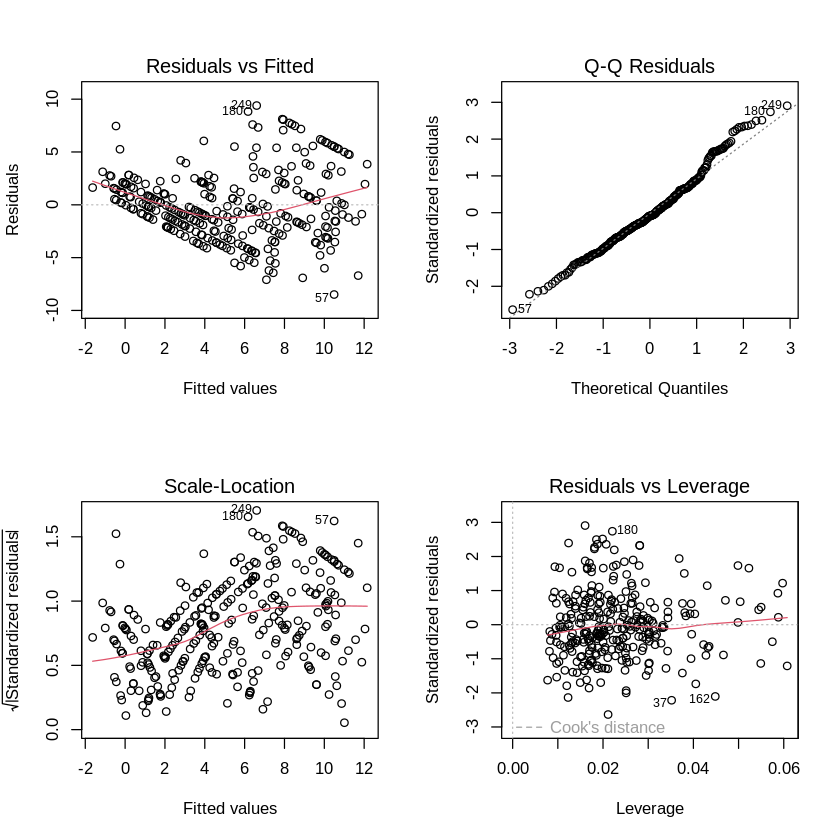

In [ ]:
par(mfrow = c(2,2))
plot(model3)

In [ ]:
# Compute studentized residuals
student_resid <- rstudent(model3)

# Find indices of observations with residuals > 2.25 or < -2.25
high_resid_indices <- which(abs(student_resid) > 2.25)

# View the studentized residuals for these points
high_resid_values <- student_resid[high_resid_indices]
print(high_resid_values)

       45        51        57        67       101       180       224       236 
 2.380181  2.283871 -2.661664  2.518636  2.339326  2.770577  2.375206  2.343318 
      249       271       274 
 2.944670  2.413984  2.536896 


Let's take a look at some of the high residual points and look for anomalies.

In [ ]:
train[high_resid_indices, c('Season', 'Team', 'Seed')]

Season,Team,Seed
<int>,<chr>,<int>
2021,Milwaukee Bucks,3
2020,Miami Heat,4
2007,Dallas Mavericks,1
2007,San Antonio Spurs,3
2011,Memphis Grizzlies,8
2010,Boston Celtics,4
2006,Dallas Mavericks,4
2002,Los Angeles Lakers,3
2004,Detroit Pistons,3




*   **2023 Heat**: Beat the 1 seed Bucks in the first round, but the Bucks were without there MVP caliber player, Giannis, for half the series.
*   **2012 Bulls**: Lost to 8 seed 76ers in the first round, but in game 1 of the series D Rose tore his ACL.
*   **2012 76ers**: Beat the 1 seed Bulls, but that may be due to an injury to the Bulls star player.
*   **2013 Thunder**: Lost in second round to the Grizzlies, but they were missing their second best player Russell Westbrook.

<br>
Let's try to remove these data points from the dataset and rerun the model




### Model After Removing Outliers

In [ ]:
model4 <- lm(Wins ~ scaled_TO_Forced + scaled_TS_percent + scaled_Def_TOV_percent +
             scaled_DRB_percent + Top10_Scorer + scaled_Seed,
           data = train)

In [ ]:
summary(model4)


Call:
lm(formula = Wins ~ scaled_TO_Forced + scaled_TS_percent + scaled_Def_TOV_percent + 
    scaled_DRB_percent + Top10_Scorer + scaled_Seed, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4928 -2.1329 -0.2901  1.9784  9.3955 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.51134    0.30035  15.020   <2e-16 ***
scaled_TO_Forced        0.03469    0.68265   0.051   0.9595    
scaled_TS_percent       0.64765    0.27076   2.392   0.0174 *  
scaled_Def_TOV_percent  0.11404    0.65647   0.174   0.8622    
scaled_DRB_percent      0.40820    0.24810   1.645   0.1010    
Top10_Scorer            0.62956    0.34523   1.824   0.0692 .  
scaled_Seed            -3.24496    0.22775 -14.248   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.258 on 295 degrees of freedom
Multiple R-squared:  0.5404,	Adjusted R-squared:  0.531 
F-statistic: 57.81 on 6 and 295 DF,  p

In [ ]:
rmse(model4)

[1] 3.220143

Improved $R^2$ value and RMSE.

### Model with Unscaled Values

In [ ]:
unscaled_values_model<- lm(Wins ~ FG + FGA + FG_percent + X3P +
             X3P_percent + X2P + X2PA + X2P_percent + FT +
             FTA + FT_percent + ORB + DRB + TRB + AST +
             STL + BLK + TOV + PF + PTS + Assist_TO + Opp_FG +
             Opp_FGA + Opp_FG_percent + Opp_3P + Opp_3PA + Opp_3P_percent +
             Opp_2P + Opp_2PA + Opp_2P_percent + Opp_FT + Opp_FTA +
             Opp_FT_percent + Off_Reb_Allowed + Opp_DRB + Opp_Total_Reb +
             Opp_AST + Opp_STL + TO_Forced + Points_Allowed + Age +
             MOV + SOS + SRS + ORtg + DRtg + NRtg + Pace +
             FTr + X3PAr + TS_percent + eFG_percent + ORB_percent +
             FT_FGA + Def_eFG_percent + Def_TOV_percent + DRB_percent + Def_FT_FGA +
             win_percentage + Top10_Scorer + Top10_Rebounder + Seed,
            data = train)

In [ ]:
summary(unscaled_values_model)


Call:
lm(formula = Wins ~ FG + FGA + FG_percent + X3P + X3P_percent + 
    X2P + X2PA + X2P_percent + FT + FTA + FT_percent + ORB + 
    DRB + TRB + AST + STL + BLK + TOV + PF + PTS + Assist_TO + 
    Opp_FG + Opp_FGA + Opp_FG_percent + Opp_3P + Opp_3PA + Opp_3P_percent + 
    Opp_2P + Opp_2PA + Opp_2P_percent + Opp_FT + Opp_FTA + Opp_FT_percent + 
    Off_Reb_Allowed + Opp_DRB + Opp_Total_Reb + Opp_AST + Opp_STL + 
    TO_Forced + Points_Allowed + Age + MOV + SOS + SRS + ORtg + 
    DRtg + NRtg + Pace + FTr + X3PAr + TS_percent + eFG_percent + 
    ORB_percent + FT_FGA + Def_eFG_percent + Def_TOV_percent + 
    DRB_percent + Def_FT_FGA + win_percentage + Top10_Scorer + 
    Top10_Rebounder + Seed, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.0677 -1.8999 -0.1524  1.6966  7.5799 

Coefficients: (1 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.203e+02  3.387e+02   1.241  0.21577    
FG       

In [ ]:
rmse(unscaled_values_model)

[1] 2.723439

Slightly better metrics than with the scaled values, but the coefficients don't make much sense.

### MLR without Seed

In [ ]:
lmWithoutSeed <- lm(Wins ~ scaled_FG + scaled_FGA + scaled_FG_percent + scaled_X3P +
             scaled_X3P_percent + scaled_X2P + scaled_X2PA + scaled_X2P_percent + scaled_FT +
             scaled_FTA + scaled_FT_percent + scaled_ORB + scaled_DRB + scaled_TRB + scaled_AST +
             scaled_STL + scaled_BLK + scaled_TOV + scaled_PF + scaled_PTS + scaled_Assist_TO + scaled_Opp_FG +
             scaled_Opp_FGA + scaled_Opp_FG_percent + scaled_Opp_3P + scaled_Opp_3PA + scaled_Opp_3P_percent +
             scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_2P_percent + scaled_Opp_FT + scaled_Opp_FTA +
             scaled_Opp_FT_percent + scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb +
             scaled_Opp_AST + scaled_Opp_STL + scaled_TO_Forced + scaled_Points_Allowed + scaled_Age +
             scaled_MOV + scaled_SOS + scaled_SRS + scaled_ORtg + scaled_DRtg + scaled_NRtg + scaled_Pace +
             scaled_FTr + scaled_X3PAr + scaled_TS_percent + scaled_eFG_percent + scaled_ORB_percent +
             scaled_FT_FGA + scaled_Def_eFG_percent + scaled_Def_TOV_percent + scaled_DRB_percent + scaled_Def_FT_FGA +
             win_percentage + Top10_Scorer + Top10_Rebounder,
            data = train)

step_model <- step(lmWithoutSeed, direction = 'both')

In [ ]:
summary(step_model)


Call:
lm(formula = Wins ~ scaled_FGA + scaled_X3P + scaled_X3P_percent + 
    scaled_X2P + scaled_ORB + scaled_PF + scaled_Opp_FG + scaled_Opp_3P + 
    scaled_Opp_3PA + scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_FT + 
    scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb + 
    scaled_SRS + scaled_ORtg + scaled_NRtg + scaled_Pace + scaled_X3PAr + 
    scaled_ORB_percent + win_percentage + Top10_Scorer, data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-8.005 -2.330 -0.352  1.964  9.982 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -17.8362     3.3078  -5.392 1.49e-07 ***
scaled_FGA              -2.4239     0.6934  -3.496 0.000551 ***
scaled_X3P               7.8321     2.0100   3.897 0.000122 ***
scaled_X3P_percent      -1.6020     0.5919  -2.707 0.007218 ** 
scaled_X2P               1.4535     0.7109   2.045 0.041833 *  
scaled_ORB               2.7649     1.6091   1.718 0.086855 .  
scaled_PF        

In [ ]:
# Train RMSE
rmse(step_model)

[1] 3.173624

In [ ]:
test <- test |>
  mutate(
    step_model_predictions = predict(step_model, test)
  )

In [ ]:
# RMSE on test data
# Step 1: Calculate Squared Errors
squared_errors <- (test$Wins - test$step_model_predictions)^2

# Step 2: Compute Mean Squared Error (MSE)
mse <- mean(squared_errors)

# Step 3: Take Square Root to get RMSE
rmse <- sqrt(mse)

# Print RMSE
paste('Step Model RMSE = ', round(rmse,3))

[1] "Step Model RMSE =  4.049"

In [ ]:
season2024 <- Scaled_Values |>
  filter(Season == 2024 & Playoff == 1)

In [ ]:
season2024 <- season2024 |>
  mutate(
    mlr_win_Predictions = predict(step_model, season2024)
  ) |>
  arrange(desc(mlr_win_Predictions))


season2024[, c("Seed", "Team", 'Wins',"mlr_win_Predictions")]

Seed,Team,Wins,mlr_win_Predictions
<int>,<chr>,<int>,<dbl>
1,Boston Celtics,16,14.198570
1,Oklahoma City Thunder,6,9.741646
2,Denver Nuggets,7,8.781067
3,Minnesota Timberwolves,9,7.204757
3,Milwaukee Bucks,2,6.761393
6,Phoenix Suns,0,6.597576
8,New Orleans Pelicans,0,6.586775
4,Cleveland Cavaliers,5,5.126821
8,Miami Heat,1,4.580988


In [ ]:
squared_errors <- (season2024$Wins - season2024$mlr_win_Predictions)^2

# Step 2: Compute Mean Squared Error (MSE)
mse <- mean(squared_errors)

# Step 3: Take Square Root to get RMSE
rmse <- sqrt(mse)

# Print RMSE
paste('MLR RMSE = ', round(rmse,3))

[1] "MLR RMSE =  4.051"

## Random Forest

In [ ]:
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(randomForest)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




### Random Forest with Scaled Variables

In [ ]:
rfModel1 <- randomForest(Wins ~ scaled_FG + scaled_FGA + scaled_FG_percent + scaled_X3P +
             scaled_X3P_percent + scaled_X2P + scaled_X2PA + scaled_X2P_percent + scaled_FT +
             scaled_FTA + scaled_FT_percent + scaled_ORB + scaled_DRB + scaled_TRB + scaled_AST +
             scaled_STL + scaled_BLK + scaled_TOV + scaled_PF + scaled_PTS + scaled_Assist_TO + scaled_Opp_FG +
             scaled_Opp_FGA + scaled_Opp_FG_percent + scaled_Opp_3P + scaled_Opp_3PA + scaled_Opp_3P_percent +
             scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_2P_percent + scaled_Opp_FT + scaled_Opp_FTA +
             scaled_Opp_FT_percent + scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb +
             scaled_Opp_AST + scaled_Opp_STL + scaled_TO_Forced + scaled_Points_Allowed + scaled_Age +
             scaled_MOV + scaled_SOS + scaled_SRS + scaled_ORtg + scaled_DRtg + scaled_NRtg + scaled_Pace +
             scaled_FTr + scaled_X3PAr + scaled_TS_percent + scaled_eFG_percent + scaled_ORB_percent +
             scaled_FT_FGA + scaled_Def_eFG_percent + scaled_Def_TOV_percent + scaled_DRB_percent + scaled_Def_FT_FGA +
             win_percentage + Top10_Scorer + Top10_Rebounder + scaled_Seed,
            data = train)

In [ ]:
print(rfModel1)
rmse(rfModel1)


Call:
 randomForest(formula = Wins ~ scaled_FG + scaled_FGA + scaled_FG_percent +      scaled_X3P + scaled_X3P_percent + scaled_X2P + scaled_X2PA +      scaled_X2P_percent + scaled_FT + scaled_FTA + scaled_FT_percent +      scaled_ORB + scaled_DRB + scaled_TRB + scaled_AST + scaled_STL +      scaled_BLK + scaled_TOV + scaled_PF + scaled_PTS + scaled_Assist_TO +      scaled_Opp_FG + scaled_Opp_FGA + scaled_Opp_FG_percent +      scaled_Opp_3P + scaled_Opp_3PA + scaled_Opp_3P_percent +      scaled_Opp_2P + scaled_Opp_2PA + scaled_Opp_2P_percent +      scaled_Opp_FT + scaled_Opp_FTA + scaled_Opp_FT_percent +      scaled_Off_Reb_Allowed + scaled_Opp_DRB + scaled_Opp_Total_Reb +      scaled_Opp_AST + scaled_Opp_STL + scaled_TO_Forced + scaled_Points_Allowed +      scaled_Age + scaled_MOV + scaled_SOS + scaled_SRS + scaled_ORtg +      scaled_DRtg + scaled_NRtg + scaled_Pace + scaled_FTr + scaled_X3PAr +      scaled_TS_percent + scaled_eFG_percent + scaled_ORB_percent +      scaled_FT_FGA + s

[1] 3.346479

In [ ]:
# Let's keep only the most important predictors
importance_vals <- importance(rfModel1)

# Get the names of predictors with importance > 100
important_predictors <- rownames(importance_vals)[importance_vals[, "IncNodePurity"] > 100]
important_predictors

[1] "scaled_Opp_3P_percent" "scaled_MOV"            "scaled_SRS"           
[4] "scaled_NRtg"           "scaled_TS_percent"     "scaled_eFG_percent"   
[7] "win_percentage"        "scaled_Seed"

In [ ]:
rfModel2 <- randomForest(Wins ~ scaled_Opp_3P_percent + scaled_eFG_percent + Seed +
                         scaled_MOV + scaled_SRS + scaled_NRtg + win_percentage + scaled_TS_percent,
                        data = train)

In [ ]:
print(rfModel2)
rmse(rfModel2)


Call:
 randomForest(formula = Wins ~ scaled_Opp_3P_percent + scaled_eFG_percent +      Seed + scaled_MOV + scaled_SRS + scaled_NRtg + win_percentage +      scaled_TS_percent, data = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 10.86709
                    % Var explained: 51.83


[1] 3.296527

In [ ]:
rfData <- train |>
  mutate(
    rfwins_predictions = predict(rfModel2)
  )

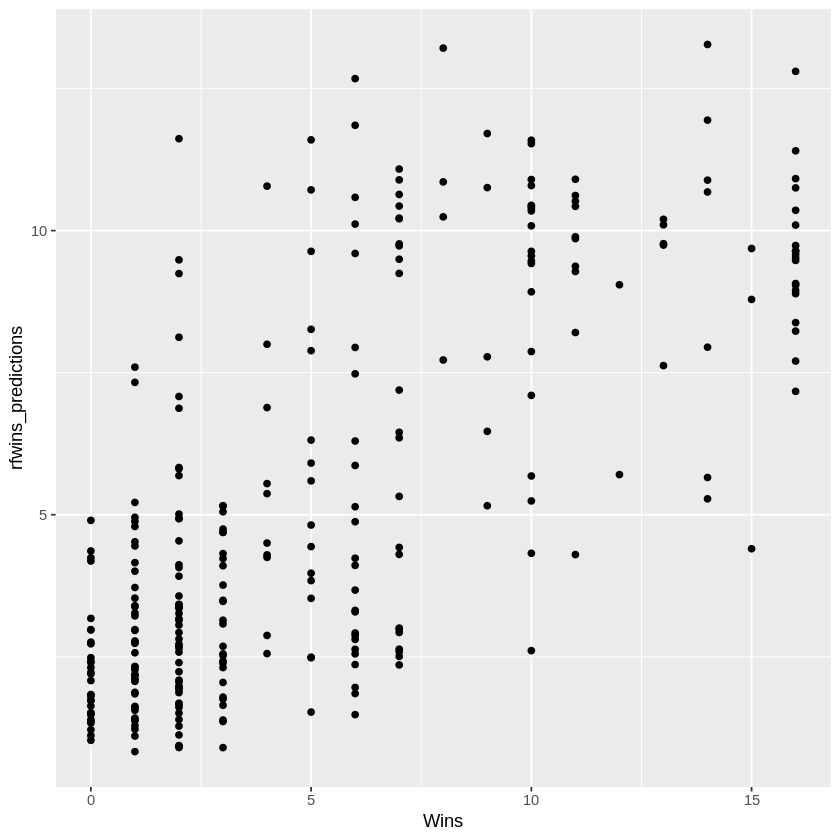

In [ ]:
rfData |>
  ggplot(aes(x = Wins, y = rfwins_predictions)) +
    geom_point()

In [ ]:
# Test RMSE
rf_test_predictions = predict(rfModel2, test)

In [ ]:
squared_errors <- (test$Wins - rf_test_predictions)^2

# Step 2: Compute Mean Squared Error (MSE)
mse <- mean(squared_errors)

# Step 3: Take Square Root to get RMSE
rmse <- sqrt(mse)

# Print RMSE
paste('RF RMSE = ', round(rmse,3))

[1] "RF RMSE =  3.302"

In [ ]:
season2024 <- season2024 |>
  mutate(
    rf_predictions = predict(rfModel2, season2024)
  ) |>
  arrange(desc(rf_predictions))


season2024[, c("Seed", "Team", 'Wins',"rf_predictions")]

Seed,Team,Wins,rf_predictions
<int>,<chr>,<int>,<dbl>
1,Oklahoma City Thunder,6,13.062933
1,Boston Celtics,16,9.318200
2,Denver Nuggets,7,9.317533
3,Minnesota Timberwolves,9,8.689267
2,New York Knicks,7,6.881267
3,Milwaukee Bucks,2,6.584300
8,New Orleans Pelicans,0,4.237400
4,Cleveland Cavaliers,5,4.211700
4,Los Angeles Clippers,2,3.901433


In [ ]:
squared_errors <- (season2024$Wins - season2024$rf_predictions)^2

# Step 2: Compute Mean Squared Error (MSE)
mse <- mean(squared_errors)

# Step 3: Take Square Root to get RMSE
rmse <- sqrt(mse)

# Print RMSE
paste('RF RMSE = ', round(rmse,3))

[1] "RF RMSE =  4.126"

### Random Forest without Scaled Variables

In [ ]:
rfWithUnscaled<- randomForest(Wins ~ FG + FGA + FG_percent + X3P +
             X3P_percent + X2P + X2PA + X2P_percent + FT +
             FTA + FT_percent + ORB + DRB + TRB + AST +
             STL + BLK + TOV + PF + PTS + Assist_TO + Opp_FG +
             Opp_FGA + Opp_FG_percent + Opp_3P + Opp_3PA + Opp_3P_percent +
             Opp_2P + Opp_2PA + Opp_2P_percent + Opp_FT + Opp_FTA +
             Opp_FT_percent + Off_Reb_Allowed + Opp_DRB + Opp_Total_Reb +
             Opp_AST + Opp_STL + TO_Forced + Points_Allowed + Age +
             MOV + SOS + SRS + ORtg + DRtg + NRtg + Pace +
             FTr + X3PAr + TS_percent + eFG_percent + ORB_percent +
             FT_FGA + Def_eFG_percent + Def_TOV_percent + DRB_percent + Def_FT_FGA +
             win_percentage + Top10_Scorer + Top10_Rebounder + Seed,
            data = train)

In [ ]:
print(rfWithUnscaled)


Call:
 randomForest(formula = Wins ~ FG + FGA + FG_percent + X3P + X3P_percent +      X2P + X2PA + X2P_percent + FT + FTA + FT_percent + ORB +      DRB + TRB + AST + STL + BLK + TOV + PF + PTS + Assist_TO +      Opp_FG + Opp_FGA + Opp_FG_percent + Opp_3P + Opp_3PA + Opp_3P_percent +      Opp_2P + Opp_2PA + Opp_2P_percent + Opp_FT + Opp_FTA + Opp_FT_percent +      Off_Reb_Allowed + Opp_DRB + Opp_Total_Reb + Opp_AST + Opp_STL +      TO_Forced + Points_Allowed + Age + MOV + SOS + SRS + ORtg +      DRtg + NRtg + Pace + FTr + X3PAr + TS_percent + eFG_percent +      ORB_percent + FT_FGA + Def_eFG_percent + Def_TOV_percent +      DRB_percent + Def_FT_FGA + win_percentage + Top10_Scorer +      Top10_Rebounder + Seed, data = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 20

          Mean of squared residuals: 10.38138
                    % Var explained: 50.66


In [ ]:
# Let's keep only the most important predictors
importance_vals <- importance(rfWithUnscaled)

# Get the names of predictors with importance > 100
important_predictors <- rownames(importance_vals)[importance_vals[, "IncNodePurity"] > 100]
important_predictors

[1] "Opp_FG_percent" "Opp_3P_percent" "MOV"            "SRS"           
[5] "NRtg"           "win_percentage" "Seed"

In [ ]:
rfWithUnscaled2 <- randomForest(Wins ~ Opp_FG_percent + Opp_3P_percent + MOV + SRS +
                                  NRtg + win_percentage + Seed,
                                  data = train)

In [ ]:
print(rfWithUnscaled2)


Call:
 randomForest(formula = Wins ~ Opp_FG_percent + Opp_3P_percent +      MOV + SRS + NRtg + win_percentage + Seed, data = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 10.77229
                    % Var explained: 48.81


In [ ]:
rmse(rfWithUnscaled2)

[1] 3.282116

In [ ]:
season2024 <- season2024 |>
  mutate(
    Win_Predictions_RF = predict(rfWithUnscaled2, season2024)
  ) |>
  arrange(desc(Win_Predictions))


season2024[, c("Seed", "Team", "Win_Predictions", "Win_Predictions_RF")]

Seed,Team,Win_Predictions,Win_Predictions_RF
<int>,<chr>,<dbl>,<dbl>
1,Boston Celtics,14.477106,9.331000
1,Oklahoma City Thunder,9.207931,8.983967
2,Denver Nuggets,8.024654,8.198467
8,New Orleans Pelicans,7.568306,2.271733
3,Milwaukee Bucks,7.290842,3.659433
6,Phoenix Suns,6.374895,2.130333
3,Minnesota Timberwolves,6.140372,9.153567
4,Los Angeles Clippers,5.060408,5.396733
6,Indiana Pacers,4.713592,2.481900


Increased $R^2$ and lower RMSE. Results are fairly similar to the MLR model.

## Neural Network

In [ ]:
install.packages('nnet')
library(nnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
nn_model <- nnet(Wins ~ scaled_Opp_3P_percent + scaled_eFG_percent +
                         scaled_MOV + scaled_SRS + scaled_NRtg + win_percentage +
                         scaled_Seed + scaled_TS_percent,
                        data = train,
                        size = 5,
                        linout = TRUE,
                        maxit = 500,
                        decay = 0.01)

In [ ]:
rmse(nn_model)

[1] 2.591547

In [ ]:
nnet_train_predictions <- predict(nn_model)

In [ ]:
# Calculate R^2
ss_res <- sum((train$Wins - nnet_train_predictions)^2)
ss_tot <- sum((train$Wins - mean(train$Wins))^2)
r_squared <- 1 - (ss_res / ss_tot)
r_squared

[1] 0.7023169

In [ ]:
nn_predictions <- predict(nn_model, test)

In [ ]:
sqrt(mean((test$Wins - nn_predictions)^2))

[1] 3.567004

In [ ]:
# Using 2024 Season as Test Case with the MLR Model
season2024 <- Scaled_Values |>
  filter(Season == 2024 & Playoff == 1)

season2024 <- season2024 |>
  mutate(
    nnet_win_Predictions = predict(nn_model, season2024)
  ) |>
  arrange(desc(nnet_win_Predictions))


season2024[, c("Seed", "Team", "nnet_win_Predictions", 'Wins')]

Seed,Team,nnet_win_Predictions,Wins
<int>,<chr>,"<dbl[,1]>",<int>
1,Oklahoma City Thunder,10.198043,6
1,Boston Celtics,9.495513,16
2,Denver Nuggets,9.432650,7
3,Minnesota Timberwolves,9.408775,9
3,Milwaukee Bucks,9.367183,2
2,New York Knicks,6.930977,7
4,Los Angeles Clippers,4.059779,2
5,Orlando Magic,4.051230,3
4,Cleveland Cavaliers,4.020608,5


In summary, the neural network preforms good from a RMSE and $R^2$ standpoint, but as we observe from the 2024 predictions, the win predictions are very closely tied to the playoff seed.

## Ensembling

Each model developed so far has its own strengths and weaknesses. To leverage the advantages of all models, an ensemble approach will be employed. Specifically, stacking will be performed in this notebook, using Multiple Linear Regression (MLR), Random Forest, and Neural Network models as base learners, with another MLR model serving as the meta-learner.

In [ ]:
lm_with_seed_predictions <- predict(model4)
lm_without_seed_predictions <- predict(step_model)
rf_predictions <- predict(rfModel2)
nn_predictions <- predict(nn_model)

train <- train |>
  mutate(
    lm_seed_predictions = lm_with_seed_predictions,
    lm_no_seed_predictions = lm_without_seed_predictions,
    rf_predictions = rf_predictions,
    nn_predictions = nn_predictions
  )

In [ ]:
# Create the Meta Learner (Linear Regression)

ensemble <- lm(Wins ~ lm_no_seed_predictions + rf_predictions + nn_predictions,
                data = train)

summary(ensemble)


Call:
lm(formula = Wins ~ lm_no_seed_predictions + rf_predictions + 
    nn_predictions, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.5480 -1.6303 -0.1466  1.4371  7.3825 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -0.11002    0.28368  -0.388  0.69841    
lm_no_seed_predictions  0.35692    0.08317   4.291  2.4e-05 ***
rf_predictions         -0.30996    0.10795  -2.871  0.00438 ** 
nn_predictions          0.97189    0.08764  11.089  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.6 on 298 degrees of freedom
Multiple R-squared:  0.7044,	Adjusted R-squared:  0.7015 
F-statistic: 236.7 on 3 and 298 DF,  p-value: < 2.2e-16


All base learners are statistically significant and an $R^2$ of 0.70 was achieved.

In [ ]:
# Training Set RMSE
rmse(ensemble)

[1] 2.582328

In [ ]:
season2024 <- Scaled_Values |>
  filter(Season == 2024 & Playoff == 1)

In [ ]:
# Ensemble Function

ensemble_function <- function(dat){
  # Calculate predictions for individual models
  # Add these predictions to the data set
  dat <- dat |>
    mutate(
      lm_no_seed_predictions = predict(step_model, dat),
      rf_predictions = predict(rfModel2, dat),
      nn_predictions = predict(nn_model, dat)
    )

  # Use the predictions to calculate
  dat <- dat |>
    mutate(
      ensemble_predictions = predict(ensemble, dat)
    )

  return(dat)
}

#### Testing on Test Set

In [ ]:
test <- ensemble_function(test)

In [ ]:
# RMSE for Test Set
sqrt(mean((test$Wins - test$ensemble_predictions)^2))

[1] 3.554465

RMSE on unseen data is around 3.5 games which is below our goal of 4 games.

#### Testing on 2024 Season

In [ ]:
season2024 <- ensemble_function(season2024)

In [ ]:
season2024[,c('Seed', 'Team', 'Wins', 'lm_no_seed_predictions', 'rf_predictions', 'nn_predictions','ensemble_predictions')] |>
  arrange(desc(ensemble_predictions))

Seed,Team,Wins,lm_no_seed_predictions,rf_predictions,nn_predictions,ensemble_predictions
<int>,<chr>,<int>,<dbl>,<dbl>,"<dbl[,1]>",<dbl>
1,Boston Celtics,16,14.198570,8.636233,10.890356,12.8649942
2,Denver Nuggets,7,8.781067,9.187233,10.874141,10.7448410
1,Oklahoma City Thunder,6,9.741646,12.881167,10.890353,9.9584621
3,Milwaukee Bucks,2,6.761393,6.121167,9.577488,9.7141497
3,Minnesota Timberwolves,9,7.204757,8.849833,9.730639,9.1754544
5,Dallas Mavericks,13,4.416778,3.366233,7.442695,7.6564626
4,Los Angeles Clippers,2,4.173570,4.015900,6.500724,6.4527951
6,Phoenix Suns,0,6.597576,2.388733,4.741802,6.1128531
8,New Orleans Pelicans,0,6.586775,4.213467,4.743001,5.5445638


In [ ]:
# RMSE for 2024 Playoffs
sqrt(mean((season2024$Wins - season2024$ensemble_predictions)^2))

[1] 4.15403

The ensemble model correctly predicts the Boston Celtics as the most likely 2024 NBA Champions. Interestingly, its predictions closely align with the betting odds published by this [sports betting organization](https://therookiewire.usatoday.com/story/sports/nba/rookie/2024/04/20/nba-playoffs-2024-the-complete-championship-odds-for-every-team/77595762007/).

**Betting Odds (Top 8 Teams)**:

1. Celtics +160

2. Nuggets +300

3. Clippers +1300

4. Bucks +1400

5. 76ers +1400

6. Mavericks +1600

7. Thunder +1600

8. Suns +1800

**Ensemble Model Predictions (Expected Playoff Wins)**:

1. Celtics – 12.8

2. Nuggets – 10.7

3. Thunder – 10.0

4. Bucks – 9.7

5. Timberwolves – 9.2

6. Mavericks – 7.7

7. Clippers – 6.5

8. Suns – 6.1

<br>
As shown, the model's predictions closely mirror the betting market. Both ranked the Celtics as title favorites, followed by the Nuggets. Of the top eight teams by betting odds, the ensemble model included seven, only substituting the 76ers with the Timberwolves. This substitution appears justified in hindsight, as the Timberwolves reached the Western Conference Finals.

#### Testing on 2021 Season

The 2021 NBA Playoffs was what sparked my interest in this project, so I wanted to see how my model fared this season. You can compare my models results to these [betting odds](https://www.sportsbettingdime.com/news/nba/updated-2021-championship-odds-all-16-playoff-teams/).

In [ ]:
season2021 <- Scaled_Values |>
  filter(Season == 2021 & Playoff == 1)

In [ ]:
season2021 <- ensemble_function(season2021)

In [ ]:
season2021[,c('Seed', 'Team', 'Wins', 'lm_no_seed_predictions', 'rf_predictions', 'nn_predictions','ensemble_predictions')] |>
  arrange(desc(ensemble_predictions))

Seed,Team,Wins,lm_no_seed_predictions,rf_predictions,nn_predictions,ensemble_predictions
<int>,<chr>,<int>,<dbl>,<dbl>,"<dbl[,1]>",<dbl>
2,Brooklyn Nets,7,11.18937116,8.620167,10.890296,11.7958792
1,Utah Jazz,6,8.94255800,7.431600,10.890356,11.3624208
1,Philadelphia 76ers,7,6.72236013,8.151200,10.876486,10.3334631
3,Denver Nuggets,4,7.51333922,4.688400,9.043489,9.9076500
4,Los Angeles Clippers,10,7.60644849,7.707233,9.854751,9.7936113
2,Phoenix Suns,14,8.74624955,13.795767,10.890303,9.3196465
3,Milwaukee Bucks,16,9.44626106,12.378167,8.825294,8.0019406
5,Atlanta Hawks,10,4.99568054,6.664067,7.004506,6.4150069
4,New York Knicks,1,3.96482278,3.993600,4.800540,4.7328132


In [ ]:
# RMSE for 2021 Playoffs
sqrt(mean((season2021$Wins - season2021$ensemble_predictions)^2))

[1] 3.646048

## Summary

This project explored the use of regular season performance metrics to predict postseason success in the NBA. Several models were developed and evaluated for this purpose, culminating in a stacked ensemble model that combines the strengths of Multiple Linear Regression, Random Forest, and Neural Network approaches. The final ensemble model achieved strong performance in terms of both RMSE and R².

However, it’s important to recognize that basketball is inherently unpredictable. No machine learning model can fully capture the complexity and human element of the game. After all, the uncertainty is part of what makes sports so compelling.

That said, this model has practical value. An NBA front office could use a tool like this to assess a team's potential for a deep playoff run, helping inform decisions at the trade deadline or during the offseason. Similarly, sports betting analysts might leverage the model’s outputs to validate or challenge existing odds. While no model will ever be flawless, this project demonstrates that data-driven analysis and machine learning can provide meaningful insights into playoff outcomes; insights which can inform smarter decisions both on and off the court.
